<a href="https://colab.research.google.com/github/asuender/deepdream/blob/main/DeepDream_Reformulated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepDream: Direct Latent Optimization

This notebook implements Direct Latent Optimization using CLIP. It optimizes image pixels to match a text prompt while preserving the original topology using Weighted Total Variation (TV) loss.

## 1. Setup

In [3]:
!wget https://raw.githubusercontent.com/Gal-Lahat/CLIP-DeepDream/refs/heads/main/requirements.txt

--2026-01-08 09:08:18--  https://raw.githubusercontent.com/Gal-Lahat/CLIP-DeepDream/refs/heads/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]      81  --.-KB/s    in 0s      

2026-01-08 09:08:18 (3.40 MB/s) - ‘requirements.txt’ saved [81/81]



In [4]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.3 MB/s eta 0:00:00


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
from torchvision.transforms import Normalize, ToTensor, ToPILImage, RandomAffine
import open_clip
from PIL import Image, ImageFilter
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import cv2

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 2. Load Model
Using **ViT-H-14** (Vision Transformer Huge) for semantic understanding.

In [6]:
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_image_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_text_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_basic_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_s13m_b4k'),
 ('ViT-

In [2]:
model_name = 'ViT-L-14'
pretrained = 'laion2b_s32b_b82k'
print(f"Loading {model_name}...")
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained, device=device, precision='fp16')
tokenizer = open_clip.get_tokenizer(model_name)

Loading ViT-L-14...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

## 3. Core Components
Includes `WeightedTVLoss` for topology preservation and `MakeCutouts` for robust optimization.

In [3]:
class WeightedTVLoss(nn.Module):
    def forward(self, img, weight_map):
        h_diff = torch.pow((img[:,:,1:,:] - img[:,:,:-1,:]), 2)
        w_diff = torch.pow((img[:,:,:,1:] - img[:,:,:,:-1]), 2)

        h_weight = weight_map[:,:,:-1,:]
        w_weight = weight_map[:,:,:,:-1]

        h_tv = (h_diff * h_weight).sum()
        w_tv = (w_diff * w_weight).sum()

        return h_tv + w_tv

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.0):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        self.augs = torch.nn.Sequential(
            RandomAffine(degrees=7, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        )
        self.noise_fac = 0.05

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []

        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutout = F.interpolate(cutout, (self.cut_size, self.cut_size), mode='bilinear', align_corners=False)
            cutouts.append(cutout)

        cutouts = torch.cat(cutouts)
        cutouts = self.augs(cutouts)

        if self.noise_fac:
            facs = cutouts.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            cutouts = cutouts + facs * torch.randn_like(cutouts)

        return cutouts

def create_detail_mask(image_pil, blur_radius=5, threshold=30, min=0):
    img_cv = np.array(image_pil.convert('L'))
    grad_x = cv2.Sobel(img_cv, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img_cv, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    mask = magnitude - threshold
    mask = mask / 50.0 + min
    mask = np.clip(mask, 0, 1)
    mask = mask.astype(np.float32)
    kernel = np.ones((2, 2), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)
    mask_pil = Image.fromarray((mask * 255).astype(np.uint8))
    mask_pil = mask_pil.filter(ImageFilter.GaussianBlur(blur_radius))
    return ToTensor()(mask_pil).to(device).unsqueeze(0)

## 4. Optimization Loop

In [4]:
def dream_masked(image_path, text_prompt,
                 negative_prompt=None,
                 negative_weight=0.8,
                 tv_weight=0.0002,
                 octave_scales=[0.6, 1.2, 2.4, 3.8],
                 steps_per_octave=70,
                 learning_rate=0.01,
                 num_cutouts=120,
                 base_size=1024,
                 cutout_batch_size=16,
                 mask_blur=3,
                 mask_threshold=15,
                 global_view_weight=0.03,
                 gradient_blur_kernel_size=3):

    if image_path.startswith('http'):
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(image_path, headers=headers, stream=True)
        img_pil = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        img_pil = Image.open(image_path).convert('RGB')

    # Get CLIP Embeddings
    text_inputs = tokenizer([text_prompt]).to(device)
    with torch.no_grad(), torch.cuda.amp.autocast():
        target_embed = model.encode_text(text_inputs).detach()
        target_embed = target_embed / target_embed.norm(dim=-1, keepdim=True)

    neg_embed = None
    if negative_prompt:
        neg_inputs = tokenizer([negative_prompt]).to(device)
        with torch.no_grad(), torch.cuda.amp.autocast():
            neg_embed = model.encode_text(neg_inputs).detach()
            neg_embed = neg_embed / neg_embed.norm(dim=-1, keepdim=True)

    current_tensor = None
    tv_loss_fn = WeightedTVLoss()

    for idx, scale in enumerate(octave_scales):
        new_width = int(base_size * scale)
        new_height = int(base_size * scale)
        print(f"\n--- Octave {idx+1}: {new_width}x{new_height} ---")

        if current_tensor is None:
            img_resized = img_pil.resize((new_width, new_height), Image.LANCZOS)
            img_tensor = ToTensor()(img_resized).unsqueeze(0).to(device)
        else:
            img_tensor = F.interpolate(current_tensor, size=(new_height, new_width), mode='bicubic', align_corners=False)

        img_tensor = img_tensor.detach().requires_grad_(True)
        optimizer = optim.Adam([img_tensor], lr=learning_rate)

        # Generate Smoothness Map
        current_pil = ToPILImage()(img_tensor.squeeze(0).cpu())
        detail_mask = create_detail_mask(current_pil, blur_radius=mask_blur, threshold=mask_threshold)
        smoothness_map = torch.pow(1.0 - detail_mask, 2)

        make_cutouts = MakeCutouts(224, cutout_batch_size, cut_pow=1.0)

        for i in range(steps_per_octave):
            optimizer.zero_grad()

            # Global View
            global_view = F.interpolate(img_tensor, (224, 224), mode='bilinear', align_corners=False)
            global_norm = (global_view - torch.tensor([0.48145466, 0.4578275, 0.40821073], device=device).view(1,3,1,1)) / \
                          torch.tensor([0.26862954, 0.26130258, 0.27577711], device=device).view(1,3,1,1)

            with torch.cuda.amp.autocast():
                global_embed = model.encode_image(global_norm)
                global_embed = global_embed / global_embed.norm(dim=-1, keepdim=True)
                global_dists = (global_embed @ target_embed.T).clamp(-0.999, 0.999)
                global_loss = torch.acos(global_dists) * 2 / np.pi
                global_loss = global_loss.mean()

            (global_loss * global_view_weight).backward(retain_graph=True)

            total_loss = 0
            num_batches = num_cutouts // cutout_batch_size

            for _ in range(num_batches):
                cutouts = make_cutouts(img_tensor)
                cutouts_norm = (cutouts - torch.tensor([0.48145466, 0.4578275, 0.40821073], device=device).view(1,3,1,1)) / \
                               torch.tensor([0.26862954, 0.26130258, 0.27577711], device=device).view(1,3,1,1)

                with torch.cuda.amp.autocast():
                    image_embeds = model.encode_image(cutouts_norm)
                    image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)

                    pos_sim = (target_embed @ image_embeds.T).mean()
                    loss = 1 - pos_sim

                    if neg_embed is not None:
                        neg_sim = (neg_embed @ image_embeds.T).mean()
                        loss = loss + (negative_weight * neg_sim)

                    loss = loss + (tv_weight * tv_loss_fn(img_tensor, smoothness_map))

                (loss / num_batches).backward()
                total_loss += loss.item()

            if img_tensor.grad is not None:
                img_tensor.grad = TF.gaussian_blur(img_tensor.grad, kernel_size=gradient_blur_kernel_size, sigma=0.5)

            if img_tensor.grad is not None:
                g = img_tensor.grad
                grad_contrast_pow = 1.5
                g_max = torch.abs(g).max() + 1e-8
                g_norm = g / g_max
                g_new = torch.sign(g_norm) * torch.abs(g_norm).pow(grad_contrast_pow)
                img_tensor.grad = g_new * g_max

            optimizer.step()

            with torch.no_grad():
                img_tensor.clamp_(0, 1)

            if i % 10 == 0:
                print(f"  Step {i} | Loss: {total_loss / num_batches:.4f}")

        current_tensor = img_tensor

    return current_tensor.cpu().detach().squeeze(0).permute(1, 2, 0).numpy()

## 5. Execution

/tmp/ipython-input-613707558.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
/tmp/ipython-input-613707558.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
/tmp/ipython-input-613707558.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-613707558.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



--- Octave 1: 307x307 ---
  Step 0 | Loss: 0.9621
  Step 10 | Loss: 0.8067
  Step 20 | Loss: 0.7592
  Step 30 | Loss: 0.7248

--- Octave 2: 614x614 ---
  Step 0 | Loss: 0.7358
  Step 10 | Loss: 0.7308
  Step 20 | Loss: 0.7208
  Step 30 | Loss: 0.6970

--- Octave 3: 1228x1228 ---
  Step 0 | Loss: 0.7295
  Step 10 | Loss: 0.7394
  Step 20 | Loss: 0.7378
  Step 30 | Loss: 0.7406

--- Octave 4: 1945x1945 ---
  Step 0 | Loss: 0.7953


/tmp/ipython-input-613707558.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-613707558.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-613707558.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Step 10 | Loss: 0.7932


/tmp/ipython-input-613707558.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-613707558.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-613707558.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-613707558.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-613707558.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-613707558.py:68:

  Step 20 | Loss: 0.7965
  Step 30 | Loss: 0.8017


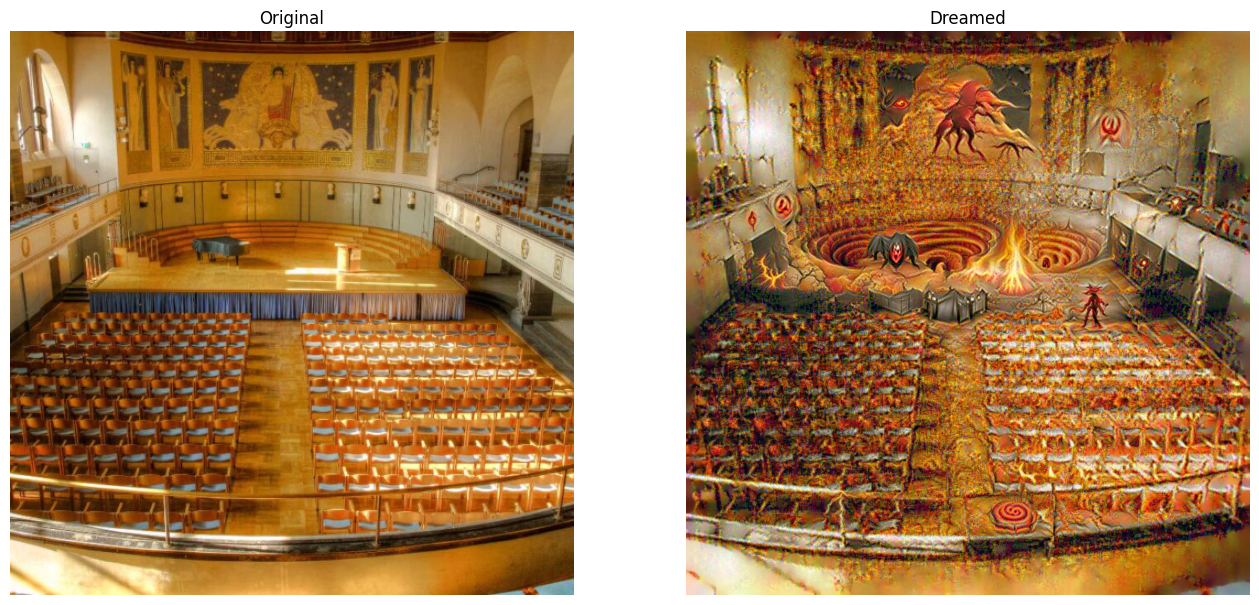

Saved full-resolution image as dream_result_fullres.png


In [6]:
# --- Configuration ---
IMAGE_URL = "aula.jpeg"
PROMPT = """
<role>
  You are the essence of a blistering nightmare nightmare.
</role>
<mission>
  Infect the existing structure of this room with the atmosphere of hell. Twist the current reality into a suffocating, infernal landscape without adding new objects.
</mission>
<atmosphericDirectives>
The air should look heavy, shimmering with heat haze and sulfurous smoke. The lighting must be changed to deep, oppressive reds and searing oranges, with shadows that feel alive and consuming.
</atmosphericDirectives>
<textureDirectives>
Every surface in the image (desks, walls, floor) should be overlaid with textures of blistering heat, molten cracks, charred organic matter, and writhing, abstract patterns. The geometry of the room should feel melted, warped, and agonizing.
</textureDirectives>
"""

NEG_PROMPT = """
text, noise, grain, blur, watermark, jpeg artifacts, low quality image, color noise, signature,
blue, green, cool colors, daylight, sunlight, clean, tidy, organized, safety,
fluorescent light, sterile, clinical, heaven, holy, smooth, flat
"""

# Optimization Hyperparameters
NEGATIVE_WEIGHT = 0.8
TV_WEIGHT = 0.0002
GLOBAL_VIEW_WEIGHT = 0.03

# Resolution & Scale
BASE_SIZE = 512
OCTAVE_SCALES = [0.6, 1.2, 2.4, 3.8]

# Performance & Quality
STEPS_PER_OCTAVE = 40
LEARNING_RATE = 0.01
NUM_CUTOUTS = 120
CUTOUT_BATCH_SIZE = 16

# Masking & Details
MASK_THRESHOLD = 15
MASK_BLUR = 3
GRADIENT_BLUR_KERNEL_SIZE = 3

# --- Run ---
original = Image.open(IMAGE_URL).convert("RGB")

result = dream_masked(
    IMAGE_URL,
    PROMPT,
    negative_prompt=NEG_PROMPT,
    negative_weight=NEGATIVE_WEIGHT,
    tv_weight=TV_WEIGHT,
    octave_scales=OCTAVE_SCALES,
    steps_per_octave=STEPS_PER_OCTAVE,
    learning_rate=LEARNING_RATE,
    num_cutouts=NUM_CUTOUTS,
    base_size=BASE_SIZE,
    cutout_batch_size=CUTOUT_BATCH_SIZE,
    mask_threshold=MASK_THRESHOLD,
    mask_blur=MASK_BLUR,
    global_view_weight=GLOBAL_VIEW_WEIGHT,
    gradient_blur_kernel_size=GRADIENT_BLUR_KERNEL_SIZE
)

# --- Visualize ---
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(TF.resize(original, (BASE_SIZE, BASE_SIZE)))
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result)
plt.title("Dreamed")
plt.axis('off')

plt.show()

# --- Save ---
if result.dtype != np.uint8:
    result_to_save = np.clip(result * 255, 0, 255).astype(np.uint8)
else:
    result_to_save = result

image = Image.fromarray(result_to_save)
image.save("dream_result_fullres.png")
print("Saved full-resolution image as dream_result_fullres.png")